# AI Response Quality Evaluation with Gemini Flash 2.0

Sistema de evaluación híbrido:
- Agent 1: Evaluador principal (todos los casos)
- Agent 2: Verificador crítico (solo casos flagged)

Criterios evaluados:
1. ✅ Detección de alucinaciones (crítico)
2. ✅ Fidelidad a fuentes
3. ✅ Completitud
4. ✅ Relevancia
5. ✅ Coherencia lógica

## 1. Setup y Configuración

In [24]:
import pandas as pd
import json
import re
from typing import Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Import evaluator
from ai_evaluator import GeminiEvaluator, evaluation_to_dict

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 300)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("✅ Libraries imported")

✅ Libraries imported


In [25]:
# Configure Gemini API key
# OPCIÓN 1: Variable de entorno (recomendado)
# export GEMINI_API_KEY='your-api-key-here'

# OPCIÓN 2: Directamente aquí (NO COMMITEAR)
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') or ''

if GEMINI_API_KEY == 'YOUR_API_KEY_HERE':
    print("⚠️  WARNING: Configure your Gemini API key!")
    print("   Get it from: https://makersuite.google.com/app/apikey")
else:
    print("✅ API Key configured")

✅ API Key configured


## 2. Load Data

In [26]:
# Load CSV
df = pd.read_csv('./Conecta/langfuse3.csv')

print(f"Total traces: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Total traces: 605
Date range: 2025-07-30T20:08:56.929Z to 2025-08-06T19:26:05.219Z


In [27]:
# Parse JSON fields
def safe_json_parse(x):
    if pd.isna(x):
        return None
    try:
        return json.loads(x)
    except:
        return None

df['input_json'] = df['input'].apply(safe_json_parse)
df['output_json'] = df['output'].apply(safe_json_parse)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("✅ JSON fields parsed")

✅ JSON fields parsed


## 3. Extract Conversation Components

In [28]:
def extract_conversation_data(row):
    """
    Extract user question, sources, and AI response for evaluation
    Improved logic to handle misclassified internal messages
    """
    result = {
        'trace_id': row['id'],
        'session_id': row['sessionId'],
        'user_question': None,
        'sources': None,
        'ai_response': None,
        'has_complete_data': False
    }
    
    if not row['output_json'] or 'messages' not in row['output_json']:
        return result
    
    messages = row['output_json']['messages']
    
    # Separate by type
    user_questions = []
    ai_responses = []
    sources_text = None
    
    for idx, msg in enumerate(messages):
        content = ''
        msg_type = 'unknown'
        msg_name = None
        
        if isinstance(msg, dict):
            content = msg.get('content', '')
            msg_type = msg.get('type', 'unknown')
            msg_name = msg.get('name', None)
        elif isinstance(msg, list) and len(msg) == 2:  # Fixed: removed extra )
            msg_type = msg[0]
            content = msg[1]
        
        if not content or not isinstance(content, str):
            continue
        
        content_stripped = content.strip()
        
        # === EXTRACT SOURCES ===
        if '## Sources' in content:
            sources_match = re.search(r'## Sources\s*\n(.+?)(?:\n\n##|$)', content, re.DOTALL)
            if sources_match:
                sources_text = sources_match.group(1).strip()
            continue  # This message is for sources only
        
        # === FILTER SYSTEM MESSAGES ===
        # Skip internal system messages
        is_system_msg = any([
            content_stripped.startswith('##'),  # Internal headers
            content_stripped.startswith('{') and '"thought"' in content,  # Planning JSON
            content_stripped == 'handoff_to_planner()',  # Handoff calls
            len(content_stripped) < 10,  # Very short (likely artifacts)
            # Long procedural responses (>500 chars starting with numbered list = likely AI response misclassified)
            (len(content_stripped) > 500 and re.match(r'^\d+\.', content_stripped) and msg_type == 'human')
        ])
        
        if is_system_msg:
            continue
        
        # === CLASSIFY REAL MESSAGES ===
        if msg_type == 'human' and msg_name is None:
            # Real user questions are typically:
            # - Short to medium length (<300 chars usually)
            # - Don't start with numbered lists
            # - Don't have formal procedural language
            
            is_likely_user_question = (
                len(content_stripped) < 300 or  # Short messages
                (len(content_stripped) < 600 and '?' in content)  # Questions
            )
            
            # Check if it's NOT a misclassified AI response
            is_not_ai_response = not any([
                content_stripped.startswith('Para ') and '1.' in content and '2.' in content,  # Procedural
                'Ingresa a Cliente 360' in content,  # Specific procedural instruction
                'estoy aquí para ayudarte' in content.lower(),  # AI signature phrase
                '😊' in content  # Emojis (AI uses these)
            ])
            
            if is_likely_user_question and is_not_ai_response:
                user_questions.append(content_stripped)
        
        elif msg_type == 'ai':
            # AI responses are everything that's not system messages
            ai_responses.append(content_stripped)
    
    # === SELECT BEST QUESTION AND RESPONSE ===
    # Take FIRST user question (original query) - more reliable than last
    if user_questions:
        result['user_question'] = user_questions[0]
    
    # Take LAST AI response (final answer to user)
    if ai_responses:
        result['ai_response'] = ai_responses[-1]
    
    if sources_text:
        result['sources'] = sources_text
    
    # Only mark as complete if we have all three components
    result['has_complete_data'] = all([
        result['user_question'],
        result['sources'],
        result['ai_response']
    ])
    
    return result

# Extract conversation data
print("Extracting conversation components with improved logic...")
conversation_data = []
for idx, row in df.iterrows():
    conv = extract_conversation_data(row)
    conversation_data.append(conv)

conv_df = pd.DataFrame(conversation_data)

print(f"\n✅ Extracted {len(conv_df)} conversations")
print(f"   Complete data (question + sources + response): {conv_df['has_complete_data'].sum()}")
print(f"   Ready for evaluation: {conv_df['has_complete_data'].sum()}")

Extracting conversation components with improved logic...

✅ Extracted 605 conversations
   Complete data (question + sources + response): 150
   Ready for evaluation: 150


In [29]:
# Filter to only conversations with complete data
eval_df = conv_df[conv_df['has_complete_data']].copy()

print(f"Conversations to evaluate: {len(eval_df)}")
print(f"\nSample conversation:")
print("="*100)
sample = eval_df.iloc[0]
print(f"USER QUESTION:\n{sample['user_question']}")
print(f"\nSOURCES:\n{sample['sources'][:500]}...")
print(f"\nAI RESPONSE:\n{sample['ai_response'][:500]}...")
print("="*100)

Conversations to evaluate: 150

Sample conversation:
USER QUESTION:
informacion exogena

SOURCES:
1. Documento ID 9284: Para crear un cliente prospecto en Cliente 360 (persona natural o jurídica sin vínculos vigentes), se debe crear para radicar peticiones, quejas o reclamos. Se puede ver el paso a paso en la presentación: https://docs.google.com/presentation/d/1NkPP5K1CClshPbZNwOyDB4M--GX6lHS4YgbhLelQWQ8/preview?&&iconodrive=https://drive-thirdparty.googleusercontent.com/16/type/application/vnd.google-apps.presentation

2. Documento ID 4869: Para radicar reclamaciones por posible fraude en ...

AI RESPONSE:
¿Podría confirmar si se refiere a la ruta dentro del sistema Cliente 360 para radicar la reclamación, o a la ruta física o de atención para el cliente? Así podré darle la información más precisa....


## 4. Run Evaluation

⚠️ **COST ESTIMATE**: 
- Gemini Flash 2.0: ~$0.50 per 1,000 conversations
- Verificación adicional: +8% (~18% de casos)

Para probar, evalúa primero solo 10 conversaciones.

In [30]:
# Initialize evaluator
evaluator = GeminiEvaluator(api_key=GEMINI_API_KEY)

print("✅ Evaluator initialized with Gemini Flash 2.0")

✅ Evaluator initialized with Gemini Flash 2.0


In [31]:
# TEST: Evaluate just 10 conversations first
TEST_SIZE = 10

test_df = eval_df.head(TEST_SIZE).copy()

print(f"Running TEST evaluation on {len(test_df)} conversations...\n")

test_results = []
for idx, row in test_df.iterrows():
    print(f"Evaluating {idx+1}/{len(test_df)}: {row['trace_id'][:20]}...")
    
    try:
        evaluation = evaluator.evaluate(
            user_question=row['user_question'],
            sources=row['sources'],
            ai_response=row['ai_response'],
            trace_id=row['trace_id'],
            session_id=row['session_id']
        )
        test_results.append(evaluation_to_dict(evaluation))
        
        # Print summary
        print(f"  Overall Score: {evaluation.overall_quality.overall_score:.2f}")
        print(f"  Recommendation: {evaluation.overall_quality.recommendation}")
        if evaluation.hallucination_check.detected:
            print(f"  ⚠️  Hallucination detected: {evaluation.hallucination_check.severity}")
        print()
        
        # Optional: Small delay to avoid rate limiting (remove if not needed)
        # With paid tier you have 2000 RPM, so this is very conservative
        import time
        time.sleep(0.5)  # 0.5 seconds = max 120 requests/minute (well under 2000 RPM)
        
    except Exception as e:
        print(f"  ❌ Error: {e}\n")
        continue

test_results_df = pd.DataFrame(test_results)
print(f"\n✅ Test evaluation complete: {len(test_results_df)} results")

Running TEST evaluation on 10 conversations...

Evaluating 3/10: f5c862f3-a7ca-4943-9...


E0000 00:00:1759719126.574894   55144 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


  ⚠️  Case f5c862f3-a7ca-4943-92a0-0910d4a32e74 flagged for verification
  Overall Score: 2.40
  Recommendation: review

Evaluating 5/10: b08555d7-dca0-44a2-b...
  Overall Score: 4.20
  Recommendation: approve

Evaluating 6/10: 9b71b911-96d4-4bbe-8...
  Overall Score: 4.00
  Recommendation: approve

Evaluating 13/10: 438b785f-329d-491b-b...
  ⚠️  Case 438b785f-329d-491b-b175-d0497259b37f flagged for verification
  Overall Score: 2.00
  Recommendation: reject

Evaluating 16/10: 787cc618-d23f-4636-b...
  Overall Score: 5.00
  Recommendation: approve

Evaluating 20/10: cb339731-f0d3-4d81-b...
  ⚠️  Case cb339731-f0d3-4d81-b6cf-9a4f68bc6005 flagged for verification
  Overall Score: 2.20
  Recommendation: reject

Evaluating 28/10: a0b0c43e-6c72-4ada-a...
  Overall Score: 3.80
  Recommendation: approve

Evaluating 37/10: c1e4ceae-8ab0-4afe-b...
  Overall Score: 4.60
  Recommendation: approve

Evaluating 51/10: a7aa32da-6a8f-4314-8...
  ⚠️  Case a7aa32da-6a8f-4314-82fc-32dd40f45c12 flagged fo

In [32]:
# View test results summary
print("TEST RESULTS SUMMARY")
print("="*80)
print(f"\nOverall Scores:")
print(f"  Mean: {test_results_df['overall_score'].mean():.2f}")
print(f"  Median: {test_results_df['overall_score'].median():.2f}")
print(f"  Min: {test_results_df['overall_score'].min():.2f}")
print(f"  Max: {test_results_df['overall_score'].max():.2f}")

print(f"\nHallucinations:")
print(f"  Detected: {test_results_df['hallucination_detected'].sum()} / {len(test_results_df)}")
print(f"  Severity distribution:")
print(test_results_df['hallucination_severity'].value_counts())

print(f"\nRecommendations:")
print(test_results_df['recommendation'].value_counts())

print(f"\nQuality Tiers:")
print(test_results_df['quality_tier'].value_counts())

print(f"\nVerification Rate:")
print(f"  Cases verified: {test_results_df['verification_applied'].sum()} / {len(test_results_df)} ({test_results_df['verification_applied'].sum()/len(test_results_df)*100:.1f}%)")

TEST RESULTS SUMMARY

Overall Scores:
  Mean: 3.38
  Median: 3.60
  Min: 2.00
  Max: 5.00

Hallucinations:
  Detected: 0 / 10
  Severity distribution:
hallucination_severity
none    10
Name: count, dtype: int64

Recommendations:
recommendation
approve    6
reject     3
review     1
Name: count, dtype: int64

Quality Tiers:
quality_tier
poor          4
acceptable    3
good          2
excellent     1
Name: count, dtype: int64

Verification Rate:
  Cases verified: 4 / 10 (40.0%)


In [33]:
# Display detailed results
test_results_df[['trace_id', 'overall_score', 'hallucination_detected', 'hallucination_severity', 
                  'fidelity_score', 'completeness_score', 'recommendation']].head(10)

,trace_id,overall_score,hallucination_detected,hallucination_severity,fidelity_score,completeness_score,recommendation
0,f5c862f3-a7ca-4943-92a0-0910d4a32e74,2.4,False,none,5,1,review
1,b08555d7-dca0-44a2-b3fa-cbb3a9f801c5,4.2,False,none,4,3,approve
2,9b71b911-96d4-4bbe-8d05-05f7ac7b2e74,4.0,False,none,5,3,approve
3,438b785f-329d-491b-b175-d0497259b37f,2.0,False,none,5,1,reject
4,787cc618-d23f-4636-ba28-a014a010f882,5.0,False,none,5,5,approve
5,cb339731-f0d3-4d81-b6cf-9a4f68bc6005,2.2,False,none,5,1,reject
6,a0b0c43e-6c72-4ada-a503-313a878d7c13,3.8,False,none,5,3,approve
7,c1e4ceae-8ab0-4afe-bc92-223da884fb94,4.6,False,none,5,3,approve
8,a7aa32da-6a8f-4314-82fc-32dd40f45c12,2.2,False,none,5,1,reject
9,d137ecd7-e185-405d-a8ff-446838959b1f,3.4,False,none,5,3,approve


## 5. Run FULL Evaluation

⚠️ Una vez satisfecho con el test, ejecuta la evaluación completa:

In [34]:
# FULL EVALUATION - Uncomment when ready
# WARNING: This will cost approximately $0.50-0.60 for 1,000 conversations

# BATCH_SIZE = 50  # Process in batches
# all_results = []

# total = len(eval_df)
# print(f"Starting FULL evaluation of {total} conversations...\n")

# for i in range(0, total, BATCH_SIZE):
#     batch = eval_df.iloc[i:i+BATCH_SIZE]
#     print(f"\nBatch {i//BATCH_SIZE + 1}: Processing {i+1}-{min(i+BATCH_SIZE, total)}...")
    
#     batch_results = []
#     for idx, row in batch.iterrows():
#         try:
#             evaluation = evaluator.evaluate(
#                 user_question=row['user_question'],
#                 sources=row['sources'],
#                 ai_response=row['ai_response'],
#                 trace_id=row['trace_id'],
#                 session_id=row['session_id']
#             )
#             batch_results.append(evaluation_to_dict(evaluation))
#         except Exception as e:
#             print(f"  Error on {row['trace_id']}: {e}")
#             continue
    
#     all_results.extend(batch_results)
#     print(f"  Completed: {len(batch_results)}/{len(batch)} successful")
    
#     # Save intermediate results
#     if (i + BATCH_SIZE) % 200 == 0:
#         intermediate_df = pd.DataFrame(all_results)
#         intermediate_df.to_csv(f'evaluation_results_checkpoint_{i+BATCH_SIZE}.csv', index=False)
#         print(f"  💾 Checkpoint saved")

# results_df = pd.DataFrame(all_results)
# results_df.to_csv('evaluation_results_FULL.csv', index=False)
# print(f"\n✅ FULL evaluation complete: {len(results_df)} results saved")

print("⚠️ Uncomment code above to run full evaluation")

⚠️ Uncomment code above to run full evaluation


## 6. Analysis & Reporting

In [35]:
# Use test results for now (change to results_df after full eval)
analysis_df = test_results_df.copy()

print("COMPREHENSIVE ANALYSIS")
print("="*100)

# 0. QUESTION QUALITY ANALYSIS (NEW - only if data available)
if 'question_clarity_score' in analysis_df.columns:
    print("\n0. QUESTION QUALITY ANALYSIS")
    print("-"*100)
    print(f"Mean Clarity Score: {analysis_df['question_clarity_score'].mean():.2f} / 5")
    print(f"Mean Context Completeness: {analysis_df['question_context_completeness'].mean():.2f} / 5")
    print(f"\nQuestion Types:")
    print(analysis_df['question_type'].value_counts())
    print(f"\nAmbiguous Questions: {analysis_df['question_is_ambiguous'].sum()} / {len(analysis_df)} ({analysis_df['question_is_ambiguous'].sum()/len(analysis_df)*100:.1f}%)")
    print(f"Questions Needing Clarification: {analysis_df['question_needs_clarification'].sum()} / {len(analysis_df)} ({analysis_df['question_needs_clarification'].sum()/len(analysis_df)*100:.1f}%)")
    
    print(f"\nVague Questions (clarity ≤ 2): {(analysis_df['question_clarity_score'] <= 2).sum()} / {len(analysis_df)}")
    print(f"Specific Questions (clarity ≥ 4): {(analysis_df['question_clarity_score'] >= 4).sum()} / {len(analysis_df)}")
    
    # Correlation between question quality and response quality
    print(f"\nCorrelation Analysis:")
    print(f"  Question Clarity ↔ Overall Score: {analysis_df['question_clarity_score'].corr(analysis_df['overall_score']):.3f}")
    print(f"  Question Context ↔ Completeness: {analysis_df['question_context_completeness'].corr(analysis_df['completeness_score']):.3f}")
else:
    print("\n⚠️  QUESTION QUALITY DATA NOT AVAILABLE")
    print("-"*100)
    print("Question quality evaluation is now enabled but results were generated with old version.")
    print("Please re-run the evaluation (Cell 12) to get question quality metrics.")
    print("\nTo re-run evaluation:")
    print("  1. Go to Cell 12 (TEST evaluation)")
    print("  2. Click 'Run Cell' to re-evaluate with question-aware system")
    print("  3. Results will include question quality fields")

# 1. Overall Quality Distribution
print("\n1. OVERALL QUALITY DISTRIBUTION")
print("-"*100)
print(f"Mean Score: {analysis_df['overall_score'].mean():.2f}")
print(f"Median Score: {analysis_df['overall_score'].median():.2f}")
print(f"\nQuality Tiers:")
print(analysis_df['quality_tier'].value_counts())
print(f"\nAcceptable Rate: {(analysis_df['acceptable']).sum() / len(analysis_df) * 100:.1f}%")

# 2. Hallucination Analysis
print("\n2. HALLUCINATION ANALYSIS (CRÍTICO)")
print("-"*100)
print(f"Hallucinations Detected: {analysis_df['hallucination_detected'].sum()} / {len(analysis_df)} ({analysis_df['hallucination_detected'].sum()/len(analysis_df)*100:.1f}%)")
print(f"\nSeverity Breakdown:")
print(analysis_df['hallucination_severity'].value_counts())
print(f"\nHallucination Types:")
all_types = []
for types_str in analysis_df['hallucination_types'].dropna():
    if types_str:
        all_types.extend(types_str.split(', '))
from collections import Counter
type_counts = Counter(all_types)
for htype, count in type_counts.most_common():
    print(f"  {htype}: {count}")

# 3. Fidelity to Sources
print("\n3. FIDELITY TO SOURCES")
print("-"*100)
print(f"Mean Fidelity Score: {analysis_df['fidelity_score'].mean():.2f}")
print(f"Mean Grounding Ratio: {analysis_df['grounding_ratio'].mean():.2%}")
print(f"\nGrounding Levels:")
print(analysis_df['grounding_level'].value_counts())

# 4. Completeness
print("\n4. COMPLETENESS")
print("-"*100)
print(f"Mean Completeness Score: {analysis_df['completeness_score'].mean():.2f}")
print(f"Mean Completeness Rate: {analysis_df['completeness_rate'].mean():.2%}")

# 5. Relevance
print("\n5. RELEVANCE")
print("-"*100)
print(f"Mean Relevance Score: {analysis_df['relevance_score'].mean():.2f}")
print(f"On-topic Rate: {analysis_df['is_on_topic'].sum() / len(analysis_df) * 100:.1f}%")

# 6. Coherence
print("\n6. COHERENCE")
print("-"*100)
print(f"Mean Coherence Score: {analysis_df['coherence_score'].mean():.2f}")
print(f"Cases with Contradictions: {analysis_df['has_contradictions'].sum()}")

# 7. Recommendations
print("\n7. RECOMMENDATIONS")
print("-"*100)
print(analysis_df['recommendation'].value_counts())

# 8. Verification Stats
print("\n8. VERIFICATION STATISTICS")
print("-"*100)
print(f"Cases requiring verification: {analysis_df['verification_applied'].sum()} / {len(analysis_df)} ({analysis_df['verification_applied'].sum()/len(analysis_df)*100:.1f}%)")

COMPREHENSIVE ANALYSIS

0. QUESTION QUALITY ANALYSIS
----------------------------------------------------------------------------------------------------
Mean Clarity Score: 1.70 / 5
Mean Context Completeness: 1.70 / 5

Question Types:
question_type
vague              4
informational      4
procedural         1
troubleshooting    1
Name: count, dtype: int64

Ambiguous Questions: 10 / 10 (100.0%)
Questions Needing Clarification: 10 / 10 (100.0%)

Vague Questions (clarity ≤ 2): 9 / 10
Specific Questions (clarity ≥ 4): 0 / 10

Correlation Analysis:
  Question Clarity ↔ Overall Score: -0.426
  Question Context ↔ Completeness: -0.220

1. OVERALL QUALITY DISTRIBUTION
----------------------------------------------------------------------------------------------------
Mean Score: 3.38
Median Score: 3.60

Quality Tiers:
quality_tier
poor          4
acceptable    3
good          2
excellent     1
Name: count, dtype: int64

Acceptable Rate: 60.0%

2. HALLUCINATION ANALYSIS (CRÍTICO)
-------------

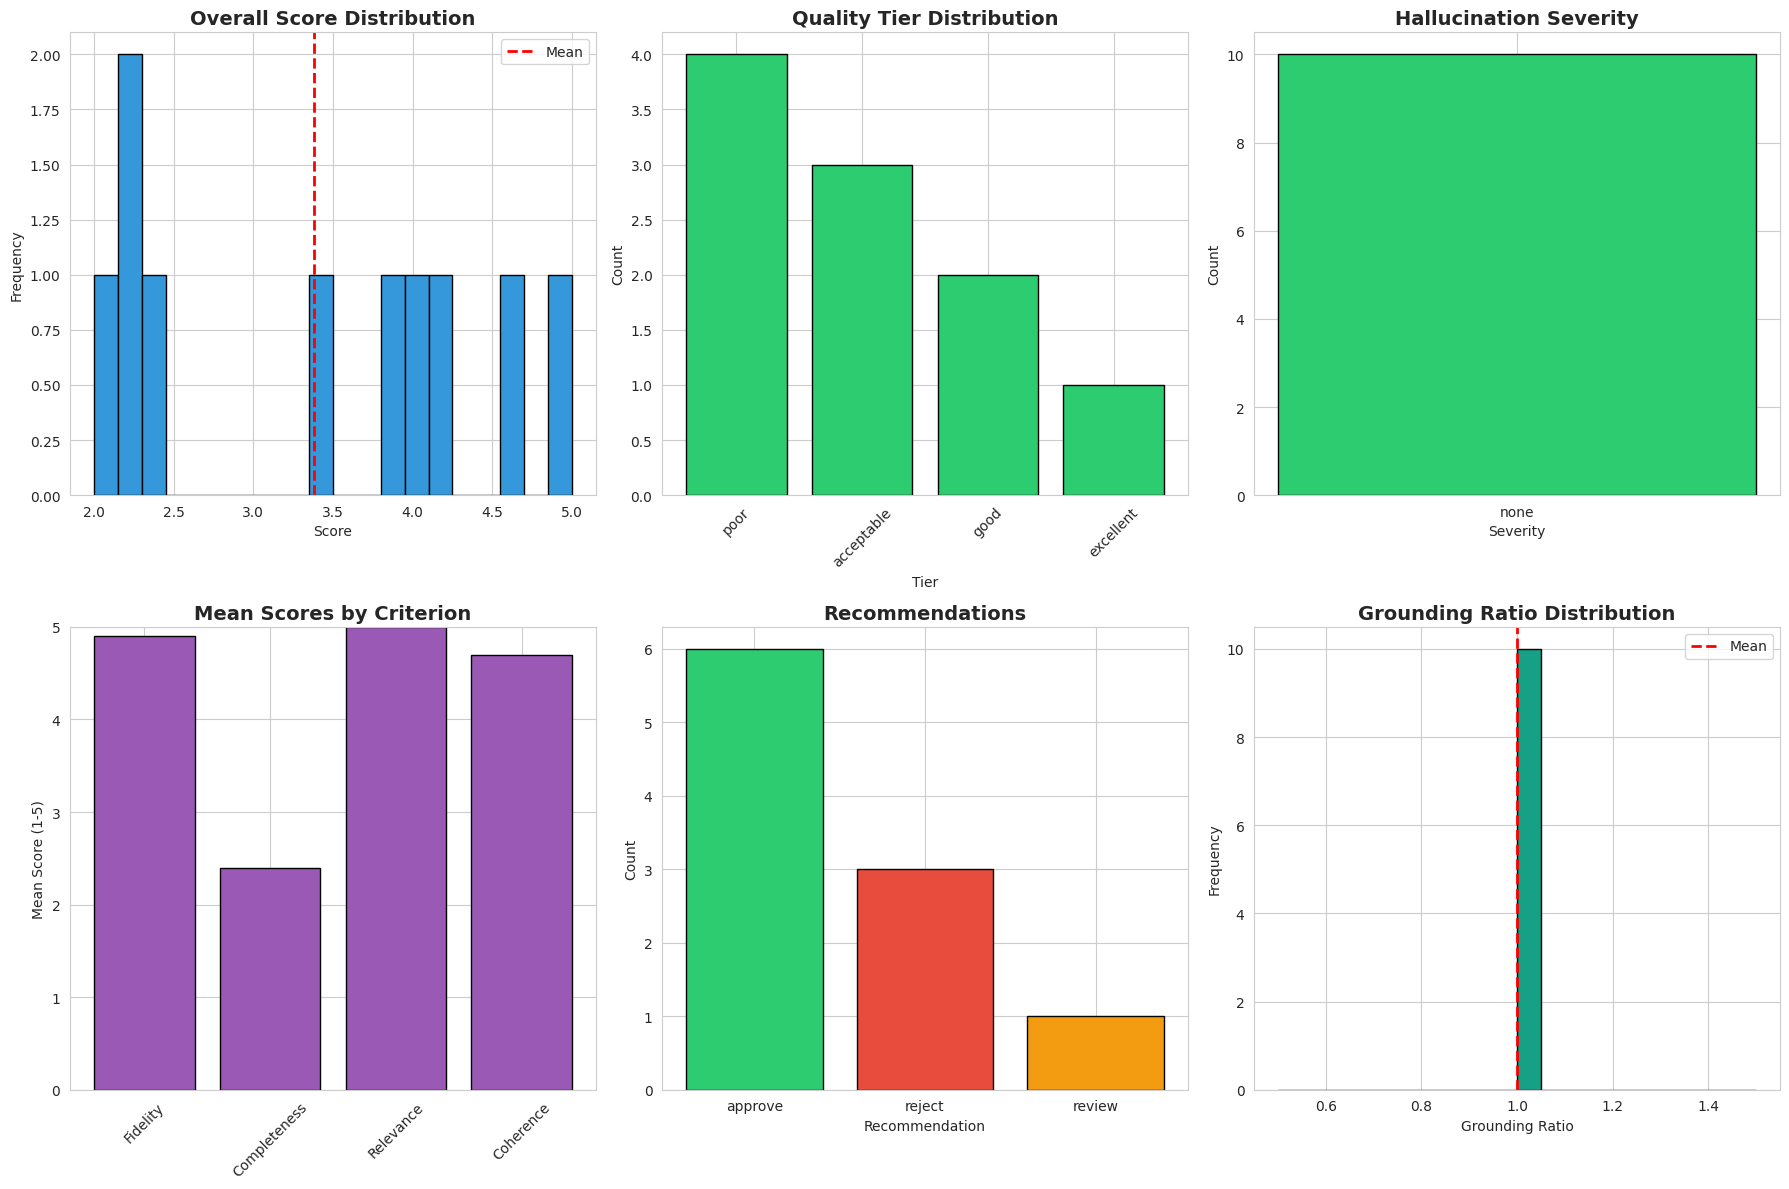


💾 Visualization saved as: evaluation_analysis.png


In [36]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Overall Score Distribution
axes[0, 0].hist(analysis_df['overall_score'], bins=20, color='#3498db', edgecolor='black')
axes[0, 0].axvline(analysis_df['overall_score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].set_title('Overall Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 2. Quality Tier Distribution
quality_counts = analysis_df['quality_tier'].value_counts()
axes[0, 1].bar(quality_counts.index, quality_counts.values, color='#2ecc71', edgecolor='black')
axes[0, 1].set_title('Quality Tier Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tier')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Hallucination Severity
severity_counts = analysis_df['hallucination_severity'].value_counts()
colors = {'none': '#2ecc71', 'minor': '#f39c12', 'major': '#e67e22', 'critical': '#e74c3c'}
bar_colors = [colors.get(x, '#95a5a6') for x in severity_counts.index]
axes[0, 2].bar(severity_counts.index, severity_counts.values, color=bar_colors, edgecolor='black')
axes[0, 2].set_title('Hallucination Severity', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Severity')
axes[0, 2].set_ylabel('Count')

# 4. Score Comparison
score_cols = ['fidelity_score', 'completeness_score', 'relevance_score', 'coherence_score']
score_means = analysis_df[score_cols].mean()
axes[1, 0].bar(range(len(score_means)), score_means.values, color='#9b59b6', edgecolor='black')
axes[1, 0].set_xticks(range(len(score_means)))
axes[1, 0].set_xticklabels(['Fidelity', 'Completeness', 'Relevance', 'Coherence'], rotation=45)
axes[1, 0].set_title('Mean Scores by Criterion', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Mean Score (1-5)')
axes[1, 0].set_ylim([0, 5])

# 5. Recommendations
rec_counts = analysis_df['recommendation'].value_counts()
rec_colors = {'approve': '#2ecc71', 'review': '#f39c12', 'reject': '#e74c3c'}
bar_colors = [rec_colors.get(x, '#95a5a6') for x in rec_counts.index]
axes[1, 1].bar(rec_counts.index, rec_counts.values, color=bar_colors, edgecolor='black')
axes[1, 1].set_title('Recommendations', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Recommendation')
axes[1, 1].set_ylabel('Count')

# 6. Grounding Ratio Distribution
axes[1, 2].hist(analysis_df['grounding_ratio'], bins=20, color='#16a085', edgecolor='black')
axes[1, 2].axvline(analysis_df['grounding_ratio'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 2].set_title('Grounding Ratio Distribution', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Grounding Ratio')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('evaluation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Visualization saved as: evaluation_analysis.png")

## 7. Identify Worst Cases

In [37]:
def display_evaluation_example(df, index, show_sources=True):
    """
    Muestra evaluación detallada de un caso específico
    Requiere df con columnas: user_question_text, ai_response_text, sources_text
    """
    if index >= len(df):
        print(f"❌ Error: Index {index} fuera de rango (máximo: {len(df)-1})")
        return
    
    row = df.iloc[index]
    
    print("="*120)
    print(f"EJEMPLO #{index+1}: {row['trace_id'][:40]}")
    print("="*120)
    
    # === PREGUNTA DEL USUARIO ===
    print("\n📝 PREGUNTA DEL USUARIO:")
    print("-"*120)
    if 'user_question_text' in row.index and pd.notna(row['user_question_text']):
        question = str(row['user_question_text'])
        if len(question) > 500:
            print(question[:500] + "...")
        else:
            print(question)
    else:
        print("⚠️  No disponible")
    print()
    
    # === CALIDAD DE LA PREGUNTA ===
    if 'question_clarity_score' in row.index and pd.notna(row['question_clarity_score']):
        print("🔍 EVALUACIÓN DE CALIDAD DE LA PREGUNTA:")
        print("-"*120)
        
        clarity = int(row['question_clarity_score'])
        print(f"Clarity Score: {clarity}/5 ", end="")
        if clarity <= 2:
            print("❌ MUY VAGA")
        elif clarity >= 4:
            print("✅ MUY ESPECÍFICA")
        else:
            print("⚠️  MODERADA")
        
        print(f"Context Completeness: {int(row['question_context_completeness'])}/5")
        print(f"Question Type: {row['question_type']}")
        print(f"Is Ambiguous: {'Sí ⚠️' if row['question_is_ambiguous'] else 'No ✅'}")
        print(f"Needs Clarification: {'Sí ⚠️' if row['question_needs_clarification'] else 'No ✅'}")
        
        missing_info = str(row['question_missing_information'])
        if missing_info and missing_info not in ['', 'nan']:
            print(f"\n❌ Información Faltante:")
            for item in missing_info.split(' | '):
                if item and item not in ['', 'nan']:
                    print(f"   • {item}")
        
        clarifications = str(row['question_clarification_needed'])
        if clarifications and clarifications not in ['', 'nan']:
            print(f"\n💡 Clarificaciones Sugeridas:")
            for item in clarifications.split(' | '):
                if item and item not in ['', 'nan']:
                    print(f"   • {item}")
        
        print(f"\n📊 Explicación del Evaluador:")
        explanation = str(row['question_explanation'])
        if len(explanation) > 300:
            print(f"   {explanation[:300]}...")
        else:
            print(f"   {explanation}")
        print()
    
    # === RESPUESTA DEL AI ===
    print("🤖 RESPUESTA DEL AI:")
    print("-"*120)
    if 'ai_response_text' in row.index and pd.notna(row['ai_response_text']):
        response = str(row['ai_response_text'])
        if len(response) > 600:
            print(response[:600] + "...")
        else:
            print(response)
    else:
        print("⚠️  No disponible")
    print()
    
    # === FUENTES (OPCIONAL) ===
    if show_sources and 'sources_text' in row.index and pd.notna(row['sources_text']):
        print("📚 FUENTES CONSULTADAS:")
        print("-"*120)
        sources = str(row['sources_text'])
        if len(sources) > 1000:
            print(sources[:1000] + "...\n")
        else:
            print(sources + "\n")
    
    # === EVALUACIÓN DE LA RESPUESTA ===
    print("⚖️  EVALUACIÓN DE LA RESPUESTA:")
    print("-"*120)
    
    # Overall Score
    score = row['overall_score']
    score_color = "🟢" if score >= 4 else ("🟡" if score >= 3 else "🔴")
    print(f"\n{score_color} OVERALL SCORE: {score:.2f}/5.0")
    print(f"   Quality Tier: {row['quality_tier'].upper()}")
    print(f"   Recommendation: {row['recommendation'].upper()}")
    print(f"   Acceptable: {'✅ SÍ' if row['acceptable'] else '❌ NO'}")
    
    # Hallucinations
    print(f"\n🚨 ALUCINACIONES:")
    if row['hallucination_detected']:
        severity = row['hallucination_severity']
        severity_emoji = "⚠️" if severity == 'minor' else ("🔴" if severity in ['major', 'critical'] else "")
        print(f"   {severity_emoji} Detected: SÍ")
        print(f"   Severity: {severity.upper()}")
        
        if pd.notna(row['hallucination_types']) and str(row['hallucination_types']):
            print(f"   Types: {row['hallucination_types']}")
        
        if pd.notna(row['hallucination_evidence']) and str(row['hallucination_evidence']):
            evidence = str(row['hallucination_evidence'])
            print(f"   Evidence: {evidence[:300]}")
    else:
        print(f"   ✅ No detectadas")
    
    # Individual Scores
    print(f"\n📊 SCORES INDIVIDUALES:")
    print(f"   Fidelity (fuentes):     {int(row['fidelity_score'])}/5  |  Grounding: {row['grounding_ratio']:.1%}")
    print(f"   Completeness:           {int(row['completeness_score'])}/5  |  Rate: {row['completeness_rate']:.1%}")
    print(f"   Relevance:              {int(row['relevance_score'])}/5  |  On-topic: {'✅' if row['is_on_topic'] else '❌'}")
    print(f"   Coherence:              {int(row['coherence_score'])}/5  |  Contradictions: {'❌' if row['has_contradictions'] else '✅'}")
    
    # NEW: Sources availability check
    if 'sources_had_answer' in row.index:
        print(f"\n⚠️  DISPONIBILIDAD DE RESPUESTA EN FUENTES:")
        sources_had = row['sources_had_answer']
        unnecessary_clarif = row.get('unnecessary_clarification', False)
        
        if sources_had:
            print(f"   ✅ Las fuentes SÍ contenían la respuesta directa")
            if unnecessary_clarif:
                print(f"   🔴 El AI pidió clarificación INNECESARIAMENTE (debió responder directamente)")
            else:
                print(f"   ✅ El AI proporcionó la información correctamente")
        else:
            print(f"   ⚠️  Las fuentes NO contenían la respuesta directa")
            print(f"   ✅ Es aceptable que el AI pida clarificación")
    
    # Claims Analysis
    print(f"\n🔬 ANÁLISIS DE CLAIMS:")
    total_claims = int(row['total_claims'])
    supported = int(row['supported_claims'])
    print(f"   Total claims: {total_claims}")
    print(f"   Supported: {supported} ({supported/total_claims*100:.1f}%)")
    
    unsupported = str(row['unsupported_claims'])
    if unsupported and unsupported not in ['', 'nan']:
        print(f"\n   ❌ Unsupported Claims:")
        for claim in unsupported.split(' | ')[:3]:
            if claim and claim not in ['', 'nan']:
                if len(claim) > 150:
                    print(f"      • {claim[:150]}...")
                else:
                    print(f"      • {claim}")
    
    # Completeness Details
    missing = str(row['missing_aspects'])
    if missing and missing not in ['', 'nan']:
        print(f"\n   ❌ Missing Aspects:")
        for aspect in missing.split(' | ')[:3]:
            if aspect and aspect not in ['', 'nan']:
                print(f"      • {aspect}")
    
    # Verification
    if row['verification_applied']:
        print(f"\n🔍 VERIFICACIÓN CRÍTICA:")
        print(f"   ✅ Este caso fue verificado por el agente secundario")
        verification_changed = str(row.get('verification_changed', ''))
        if verification_changed and verification_changed not in ['', 'nan']:
            print(f"   ⚠️  Cambios: {verification_changed}")
    
    # Question-Aware Adjustment
    adjustment = str(row.get('question_aware_adjustment', ''))
    if adjustment and adjustment not in ['', 'nan']:
        print(f"\n🎯 AJUSTE POR CALIDAD DE PREGUNTA:")
        print(f"   {adjustment}")
    
    # Final Reasoning
    print(f"\n💭 RAZONAMIENTO FINAL DEL EVALUADOR:")
    print("-"*120)
    reasoning = str(row['reasoning'])
    print(reasoning)
    
    print("\n" + "="*120 + "\n")

print("✅ Función display_evaluation_example() definida")
print("\nUso:")
print("  display_evaluation_example(detailed_df, 0)                    # Primer caso")
print("  display_evaluation_example(detailed_df, 3, show_sources=True) # Con fuentes")

✅ Función display_evaluation_example() definida

Uso:
  display_evaluation_example(detailed_df, 0)                    # Primer caso
  display_evaluation_example(detailed_df, 3, show_sources=True) # Con fuentes


In [38]:
# Primero, crear un dataset combinado con datos originales + evaluación
def prepare_detailed_view(evaluation_df, original_df):
    """
    Combina evaluation results con datos originales para vista detallada
    """
    # Match by trace_id
    combined = evaluation_df.copy()
    
    # Add original data
    for idx, row in combined.iterrows():
        trace_id = row['trace_id']
        original = original_df[original_df['trace_id'] == trace_id]
        
        if len(original) > 0:
            combined.at[idx, 'user_question_text'] = original.iloc[0]['user_question']
            combined.at[idx, 'ai_response_text'] = original.iloc[0]['ai_response']
            combined.at[idx, 'sources_text'] = original.iloc[0]['sources']
    
    return combined

# Create the combined dataset
detailed_df = prepare_detailed_view(analysis_df, eval_df)

print("✅ Dataset combinado creado con", len(detailed_df), "casos")
print("\nColumnas disponibles:")
print("  - Datos originales: user_question_text, ai_response_text, sources_text")
print("  - Evaluación: todos los campos de scoring y reasoning")

✅ Dataset combinado creado con 10 casos

Columnas disponibles:
  - Datos originales: user_question_text, ai_response_text, sources_text
  - Evaluación: todos los campos de scoring y reasoning


In [39]:
# Mostrar casos representativos automáticamente

print("🔍 EJEMPLOS AUTOMÁTICOS DE CASOS REPRESENTATIVOS")
print("="*120)
print()

# 1. Mejor caso (highest score)
best_idx = detailed_df['overall_score'].idxmax()
best_position = list(detailed_df.index).index(best_idx)
print("✅ MEJOR CASO (Highest Score):")
print(f"   Score: {detailed_df.loc[best_idx, 'overall_score']:.2f}")
display_evaluation_example(detailed_df, best_position)

# 2. Peor caso (lowest score)
worst_idx = detailed_df['overall_score'].idxmin()
worst_position = list(detailed_df.index).index(worst_idx)
print("\n❌ PEOR CASO (Lowest Score):")
print(f"   Score: {detailed_df.loc[worst_idx, 'overall_score']:.2f}")
display_evaluation_example(detailed_df, worst_position)

# 3. Caso con alucinación (si existe)
hallucination_cases = detailed_df[detailed_df['hallucination_detected'] == True]
if len(hallucination_cases) > 0:
    hall_idx = hallucination_cases.index[0]
    hall_position = list(detailed_df.index).index(hall_idx)
    print("\n🚨 CASO CON ALUCINACIÓN:")
    print(f"   Severity: {hallucination_cases.loc[hall_idx, 'hallucination_severity']}")
    display_evaluation_example(detailed_df, hall_position)

# 4. Caso con pregunta vaga (si existe question quality data)
if 'question_clarity_score' in detailed_df.columns:
    vague_questions = detailed_df[detailed_df['question_clarity_score'] <= 2]
    if len(vague_questions) > 0:
        vague_idx = vague_questions.index[0]
        vague_position = list(detailed_df.index).index(vague_idx)
        print("\n⚠️  CASO CON PREGUNTA VAGA:")
        print(f"   Clarity: {vague_questions.loc[vague_idx, 'question_clarity_score']}/5")
        display_evaluation_example(detailed_df, vague_position)

# 5. Caso con pregunta específica (si existe question quality data)
if 'question_clarity_score' in detailed_df.columns:
    specific_questions = detailed_df[detailed_df['question_clarity_score'] >= 4]
    if len(specific_questions) > 0:
        specific_idx = specific_questions.index[0]
        specific_position = list(detailed_df.index).index(specific_idx)
        print("\n✅ CASO CON PREGUNTA ESPECÍFICA:")
        print(f"   Clarity: {specific_questions.loc[specific_idx, 'question_clarity_score']}/5")
        display_evaluation_example(detailed_df, specific_position)

print("\n" + "="*120)
print("💡 Para ver cualquier caso específico, usa:")
print("   display_evaluation_example(detailed_df, INDEX, show_sources=True)")
print("\n💡 Para comparar dos casos:")
print("   compare_evaluations(detailed_df, INDEX1, INDEX2)")
print("="*120)

🔍 EJEMPLOS AUTOMÁTICOS DE CASOS REPRESENTATIVOS

✅ MEJOR CASO (Highest Score):
   Score: 5.00
EJEMPLO #5: 787cc618-d23f-4636-ba28-a014a010f882

📝 PREGUNTA DEL USUARIO:
------------------------------------------------------------------------------------------------------------------------
el banco acepta hipoteca con otra entidad

🔍 EVALUACIÓN DE CALIDAD DE LA PREGUNTA:
------------------------------------------------------------------------------------------------------------------------
Clarity Score: 2/5 ❌ MUY VAGA
Context Completeness: 2/5
Question Type: informational
Is Ambiguous: Sí ⚠️
Needs Clarification: Sí ⚠️

❌ Información Faltante:
   • Tipo de cliente (persona natural o jurídica)
   • Producto específico (tipo de hipoteca)
   • Si se refiere a hipotecar una propiedad ya hipotecada o subrogar una hipoteca existente

💡 Clarificaciones Sugeridas:
   • ¿Se refiere a hipotecar una propiedad que ya tiene una hipoteca con otra entidad, o a subrogar una hipoteca existente?
   • ¿Es 

## 6b. Ejemplos Detallados de Evaluación

Análisis profundo de cómo el agente evaluador está razonando sobre casos específicos.

In [40]:
# Critical cases (hallucinations)
critical_cases = analysis_df[
    (analysis_df['hallucination_detected'] == True) & 
    (analysis_df['hallucination_severity'].isin(['major', 'critical']))
].copy()

print(f"CRITICAL CASES: {len(critical_cases)} conversations with major/critical hallucinations")
print("="*150)

for idx, row in critical_cases.head(5).iterrows():
    print(f"\nTrace: {row['trace_id']}")
    print(f"Severity: {row['hallucination_severity']}")
    print(f"Overall Score: {row['overall_score']:.2f}")
    print(f"Evidence: {row['hallucination_evidence'][:500]}")
    print(f"Explanation: {row['hallucination_explanation'][:500]}")
    print("-"*150)

CRITICAL CASES: 0 conversations with major/critical hallucinations


In [41]:
# Low quality cases
low_quality = analysis_df[analysis_df['overall_score'] < 2.5].copy().sort_values('overall_score')

print(f"LOW QUALITY CASES: {len(low_quality)} conversations with score < 2.5")
print("="*150)

low_quality[['trace_id', 'overall_score', 'fidelity_score', 'completeness_score', 
             'hallucination_severity', 'recommendation', 'reasoning']].head(10)

LOW QUALITY CASES: 4 conversations with score < 2.5


,trace_id,overall_score,fidelity_score,completeness_score,hallucination_severity,recommendation,reasoning
3,438b785f-329d-491b-b175-d0497259b37f,2.0,5,1,none,reject,La respuesta es incompleta. Las fuentes contienen información relevante sobre la no aceptación de hipotecas en segundo grado y la posibilidad de un crédito adicional con garantía hipotecaria si ya se tiene una hipoteca con Davivienda. El AI debería haber proporcionado esta información en lugar d...
5,cb339731-f0d3-4d81-b6cf-9a4f68bc6005,2.2,5,1,none,reject,"La respuesta es incompleta ya que no responde la pregunta directamente, a pesar de que las fuentes contienen información relevante. Pide clarificación innecesariamente."
8,a7aa32da-6a8f-4314-82fc-32dd40f45c12,2.2,5,1,none,reject,La respuesta es incompleta porque no proporciona los montos de inembargabilidad que están disponibles en las fuentes. Pide clarificación innecesariamente.
0,f5c862f3-a7ca-4943-92a0-0910d4a32e74,2.4,5,1,none,review,"La pregunta es muy vaga, pero el AI pide clarificación innecesariamente, ya que no hay información en las fuentes para responder directamente. Sin embargo, la pregunta es tan ambigua que es aceptable que pida clarificación, pero no debería haberlo hecho de la forma en que lo hizo."


## 8. Export Results

In [42]:
# Save full results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
analysis_df.to_csv(f'evaluation_results_{timestamp}.csv', index=False)

# Save critical cases separately
if len(critical_cases) > 0:
    critical_cases.to_csv(f'critical_hallucinations_{timestamp}.csv', index=False)

# === NEW: CONVERSATIONAL-LEVEL ANALYSIS ===
print("\n" + "="*100)
print("CONVERSATIONAL-LEVEL AGGREGATION")
print("="*100)

# Group by session to get conversation-level metrics
conv_level = analysis_df.groupby('session_id').agg({
    'trace_id': 'count',  # Number of interactions per conversation
    'overall_score': ['mean', 'min', 'max'],
    'hallucination_detected': 'sum',  # Total hallucinations in conversation
    'hallucination_severity': lambda x: 'critical' if 'critical' in x.values else ('major' if 'major' in x.values else ('minor' if 'minor' in x.values else 'none')),
    'fidelity_score': 'mean',
    'completeness_score': 'mean',
    'relevance_score': 'mean',
    'coherence_score': 'mean',
    'acceptable': lambda x: all(x),  # All interactions acceptable?
    'recommendation': lambda x: 'reject' if 'reject' in x.values else ('review' if 'review' in x.values else 'approve'),
    'verification_applied': 'sum'
}).reset_index()

# Flatten column names
conv_level.columns = ['session_id', 'num_interactions', 
                      'mean_score', 'min_score', 'max_score',
                      'total_hallucinations', 'worst_severity',
                      'mean_fidelity', 'mean_completeness', 'mean_relevance', 'mean_coherence',
                      'all_acceptable', 'conversation_recommendation', 'total_verifications']

print(f"\nTotal Conversations: {len(conv_level)}")
print(f"Total Interactions: {analysis_df.shape[0]}")
print(f"Average Interactions per Conversation: {conv_level['num_interactions'].mean():.1f}")

print(f"\nConversation Quality:")
print(f"  Fully acceptable (all interactions OK): {conv_level['all_acceptable'].sum()} / {len(conv_level)} ({conv_level['all_acceptable'].sum()/len(conv_level)*100:.1f}%)")
print(f"  With hallucinations: {(conv_level['total_hallucinations'] > 0).sum()} / {len(conv_level)} ({(conv_level['total_hallucinations'] > 0).sum()/len(conv_level)*100:.1f}%)")
print(f"  With critical severity: {(conv_level['worst_severity'] == 'critical').sum()}")

print(f"\nConversation Recommendations:")
print(conv_level['conversation_recommendation'].value_counts())

# Save conversation-level analysis
conv_level.to_csv(f'conversation_level_analysis_{timestamp}.csv', index=False)
print(f"\n💾 Saved: conversation_level_analysis_{timestamp}.csv")

# Distribution of interactions per conversation
print(f"\nInteractions per Conversation:")
print(f"  Min: {conv_level['num_interactions'].min()}")
print(f"  Max: {conv_level['num_interactions'].max()}")
print(f"  Median: {conv_level['num_interactions'].median():.0f}")
print(f"  Mean: {conv_level['num_interactions'].mean():.1f}")

# === SUMMARY REPORT (UPDATED) ===
summary = {
    'evaluation_date': timestamp,
    
    # Interaction-level metrics
    'interaction_level': {
        'total_interactions': len(analysis_df),
        'mean_overall_score': float(analysis_df['overall_score'].mean()),
        'acceptable_rate': float((analysis_df['acceptable']).sum() / len(analysis_df)),
        'hallucination_rate': float(analysis_df['hallucination_detected'].sum() / len(analysis_df)),
        'critical_hallucinations': int(len(critical_cases)),
        'approval_rate': float((analysis_df['recommendation'] == 'approve').sum() / len(analysis_df)),
        'review_rate': float((analysis_df['recommendation'] == 'review').sum() / len(analysis_df)),
        'reject_rate': float((analysis_df['recommendation'] == 'reject').sum() / len(analysis_df)),
        'verification_rate': float(analysis_df['verification_applied'].sum() / len(analysis_df))
    },
    
    # Conversation-level metrics
    'conversation_level': {
        'total_conversations': int(len(conv_level)),
        'avg_interactions_per_conversation': float(conv_level['num_interactions'].mean()),
        'fully_acceptable_conversations': int(conv_level['all_acceptable'].sum()),
        'fully_acceptable_rate': float(conv_level['all_acceptable'].sum() / len(conv_level)),
        'conversations_with_hallucinations': int((conv_level['total_hallucinations'] > 0).sum()),
        'conversations_with_critical_issues': int((conv_level['worst_severity'] == 'critical').sum()),
        'mean_conversation_score': float(conv_level['mean_score'].mean()),
        'approve_rate': float((conv_level['conversation_recommendation'] == 'approve').sum() / len(conv_level)),
        'review_rate': float((conv_level['conversation_recommendation'] == 'review').sum() / len(conv_level)),
        'reject_rate': float((conv_level['conversation_recommendation'] == 'reject').sum() / len(conv_level))
    }
}

with open(f'evaluation_summary_{timestamp}.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("\n✅ EXPORTED FILES:")
print(f"  1. evaluation_results_{timestamp}.csv - Interaction-level results")
print(f"  2. conversation_level_analysis_{timestamp}.csv - Conversation-level aggregation")
if len(critical_cases) > 0:
    print(f"  3. critical_hallucinations_{timestamp}.csv - Critical cases only")
print(f"  4. evaluation_summary_{timestamp}.json - Summary statistics (both levels)")
print(f"  5. evaluation_analysis.png - Visualizations")


CONVERSATIONAL-LEVEL AGGREGATION

Total Conversations: 6
Total Interactions: 10
Average Interactions per Conversation: 1.7

Conversation Quality:
  Fully acceptable (all interactions OK): 2 / 6 (33.3%)
  With hallucinations: 0 / 6 (0.0%)
  With critical severity: 0

Conversation Recommendations:
conversation_recommendation
reject     3
approve    2
review     1
Name: count, dtype: int64

💾 Saved: conversation_level_analysis_20251005_215322.csv

Interactions per Conversation:
  Min: 1
  Max: 3
  Median: 2
  Mean: 1.7

✅ EXPORTED FILES:
  1. evaluation_results_20251005_215322.csv - Interaction-level results
  2. conversation_level_analysis_20251005_215322.csv - Conversation-level aggregation
  4. evaluation_summary_20251005_215322.json - Summary statistics (both levels)
  5. evaluation_analysis.png - Visualizations
